In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import local_binary_pattern, hog
from skimage.color import rgb2gray
import cv2
from sklearn.preprocessing import LabelBinarizer
import os


In [5]:
# Load FER 2013 dataset
def load_fer2013():
    data = pd.read_csv('../Dataset/fer2013.csv')
    return data

In [34]:
# Preprocess dataset
def preprocess_data(data):
    # Extract pixels and labels
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        faces.append(face.astype('uint8'))
    faces = np.asarray(faces)
    emotions = pd.get_dummies(data['emotion']).values
    return faces, emotions

# Feature extraction methods
def extract_lbp_features(images):
    lbp_features = []
    for image in images:
        lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
        lbp_hist = lbp_hist.astype('float')
        lbp_hist /= lbp_hist.sum()
        lbp_features.append(lbp_hist)
    return np.array(lbp_features)

def extract_hog_features(images):
    hog_features = []
    for image in images:
        feature = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        hog_features.append(feature)
    return np.array(hog_features)

def extract_sift_features(images):
    sift = cv2.SIFT_create()
    sift_features = []
    for image in images:
        kp, des = sift.detectAndCompute(image, None)
        if des is not None:
            if des.shape[0] > 50:
                des = des[:50]  # Truncate to the first 50 keypoints
            elif des.shape[0] < 50:
                des = np.pad(des, ((0, 50 - des.shape[0]), (0, 0)), mode='constant')  # Pad to 50 keypoints
            sift_features.append(des.flatten())
        else:
            sift_features.append(np.zeros(50*128))  # 50 keypoints with 128 dimensions each, zero-padded
    return np.array(sift_features)

def extract_glcm_features(images):
    glcm_features = []
    for image in images:
        glcm = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(image)
        hist = cv2.calcHist([glcm], [0], None, [256], [0,256])
        glcm_features.append(hist.flatten())
    return np.array(glcm_features)

# Train and evaluate SVM classifier
def train_evaluate_svm(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    svm = SVC(kernel='rbf', probability=True)
    svm.fit(X_train, y_train)
    
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    y_pred_prob = svm.predict_proba(X_test)
    
    return y_pred, y_pred_prob, accuracy

# Plot ROC and Confusion Matrix
def plot_roc(y_test, y_pred_prob, classes):
    lb = LabelBinarizer()
    lb.fit(classes)
    y_test_bin = lb.transform(y_test)
    
    for (i, class_) in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_test, y_pred, classes):
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap=plt.cm.Blues, values_format='g')
    plt.show()


In [19]:
# Main
data = load_fer2013()
faces, emotions = preprocess_data(data)
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.2, random_state=42)

In [14]:
# One-hot encode the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [25]:
y_train = np.argmax(y_train,axis=1)
y_test = np.argmax(y_test,axis=1)

In [26]:
y_train[0]

4

In [27]:
X_train=X_train[0:5000]
y_train=y_train[0:5000]
X_test=X_test[0:1000]
y_test=y_test[0:1000]

LBP Accuracy: 0.2440


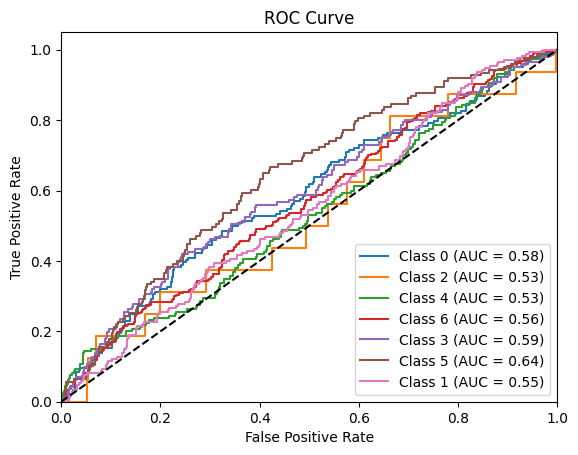

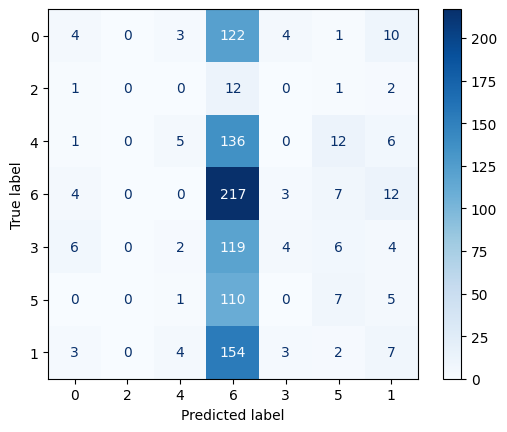

In [28]:
# LBP Features
lbp_features_train = extract_lbp_features(X_train)
lbp_features_test = extract_lbp_features(X_test)
y_pred_lbp, y_pred_prob_lbp, accuracy_lbp = train_evaluate_svm(lbp_features_train, y_train, lbp_features_test, y_test)
print(f'LBP Accuracy: {accuracy_lbp:.4f}')
plot_roc(y_test, y_pred_prob_lbp, data['emotion'].unique())
plot_confusion_matrix(y_test, y_pred_lbp, data['emotion'].unique())

HoG Accuracy: 0.4420


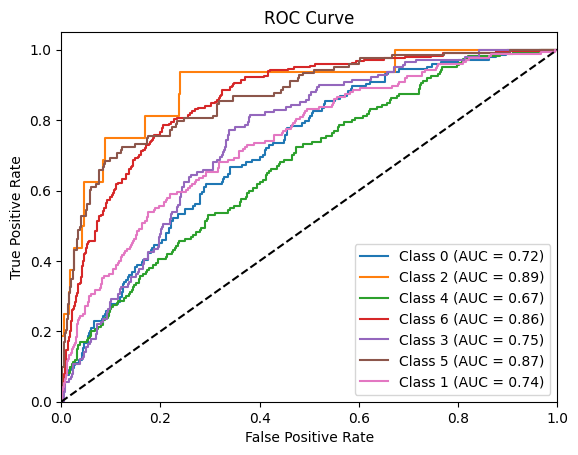

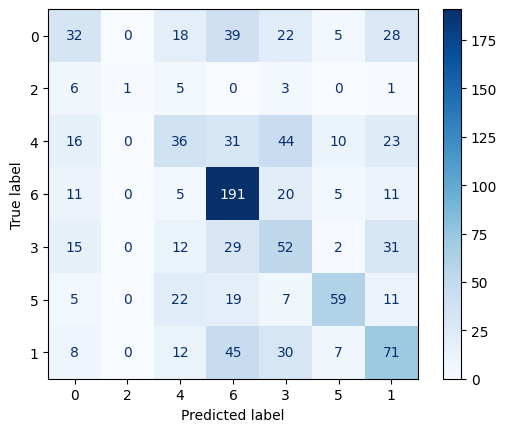

In [32]:
# HoG Features
hog_features_train = extract_hog_features(X_train)
hog_features_test = extract_hog_features(X_test)
y_pred_hog, y_pred_prob_hog, accuracy_hog = train_evaluate_svm(hog_features_train, y_train, hog_features_test, y_test)
print(f'HoG Accuracy: {accuracy_hog:.4f}')
plot_roc(y_test, y_pred_prob_hog, data['emotion'].unique())
plot_confusion_matrix(y_test, y_pred_hog, data['emotion'].unique())

SIFT Accuracy: 0.2540


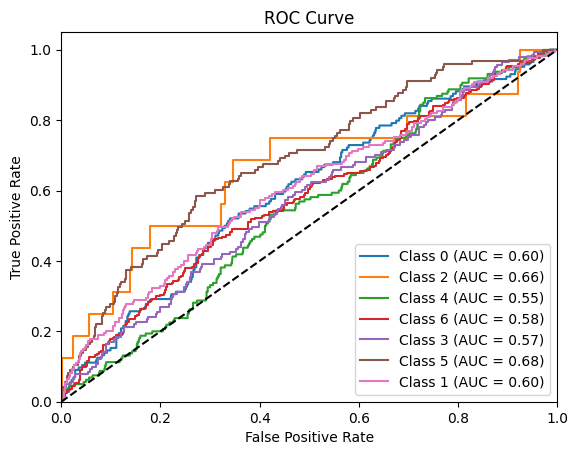

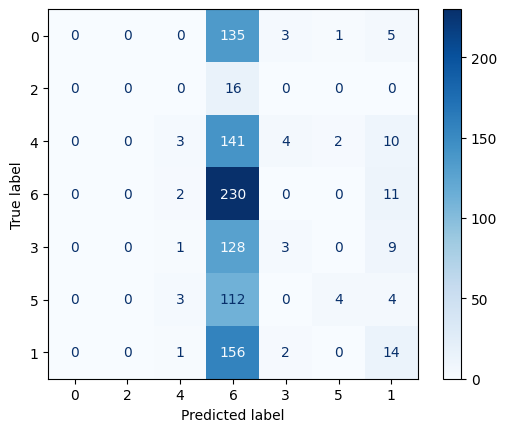

In [35]:
# SIFT Features
sift_features_train = extract_sift_features(X_train)
sift_features_test = extract_sift_features(X_test)
y_pred_sift, y_pred_prob_sift, accuracy_sift = train_evaluate_svm(sift_features_train, y_train, sift_features_test, y_test)
print(f'SIFT Accuracy: {accuracy_sift:.4f}')
plot_roc(y_test, y_pred_prob_sift, data['emotion'].unique())
plot_confusion_matrix(y_test, y_pred_sift, data['emotion'].unique())

GLCM Accuracy: 0.2610


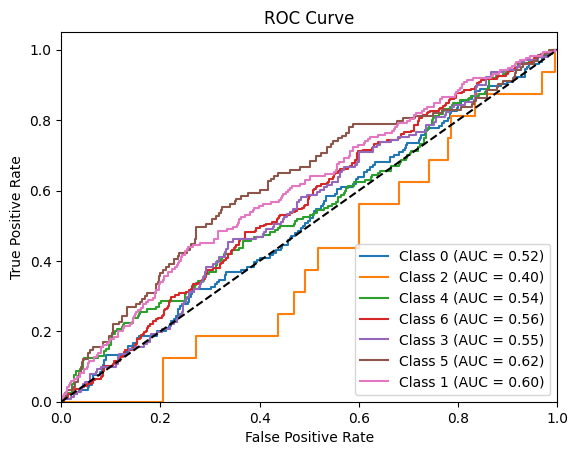

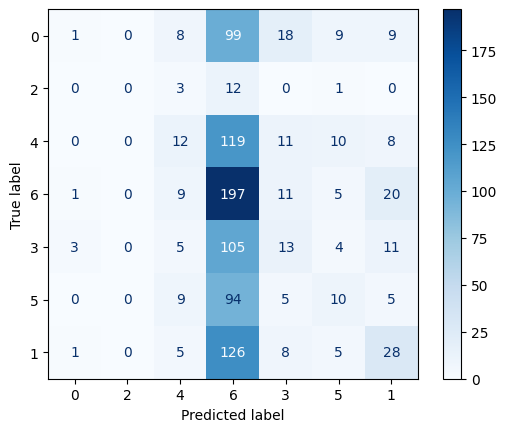

In [36]:
# GLCM Features
glcm_features_train = extract_glcm_features(X_train)
glcm_features_test = extract_glcm_features(X_test)
y_pred_glcm, y_pred_prob_glcm, accuracy_glcm = train_evaluate_svm(glcm_features_train, y_train, glcm_features_test, y_test)
print(f'GLCM Accuracy: {accuracy_glcm:.4f}')
plot_roc(y_test, y_pred_prob_glcm, data['emotion'].unique())
plot_confusion_matrix(y_test, y_pred_glcm, data['emotion'].unique())

Concatenated Features Accuracy: 0.3840


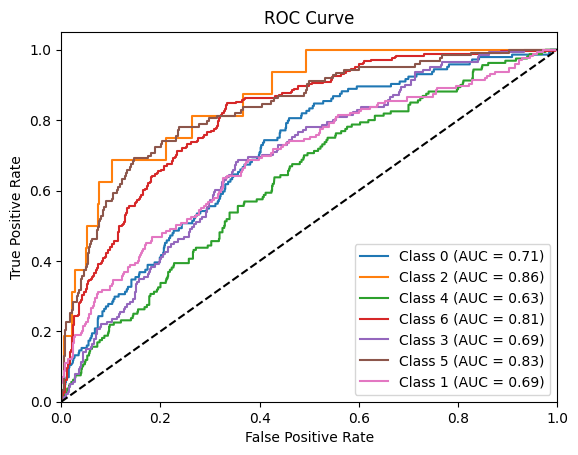

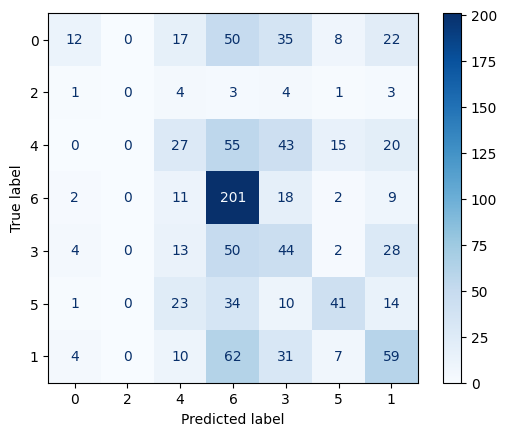

In [37]:
# Concatenate Features
concat_features_train = np.hstack((lbp_features_train, hog_features_train, sift_features_train, glcm_features_train))
concat_features_test = np.hstack((lbp_features_test, hog_features_test, sift_features_test, glcm_features_test))
y_pred_concat, y_pred_prob_concat, accuracy_concat = train_evaluate_svm(concat_features_train, y_train, concat_features_test, y_test)
print(f'Concatenated Features Accuracy: {accuracy_concat:.4f}')
plot_roc(y_test, y_pred_prob_concat, data['emotion'].unique())
plot_confusion_matrix(y_test, y_pred_concat, data['emotion'].unique())

Probability Fusion Accuracy: 0.3970


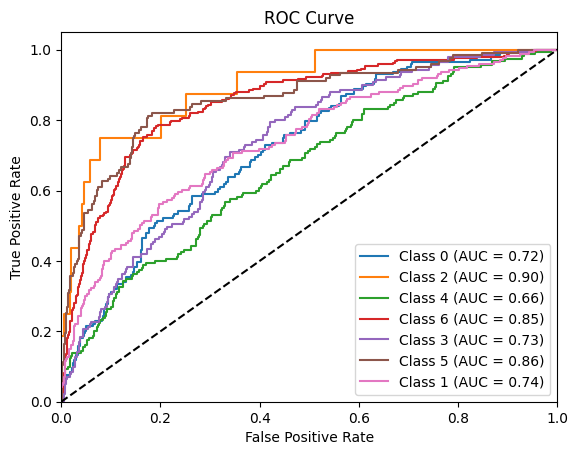

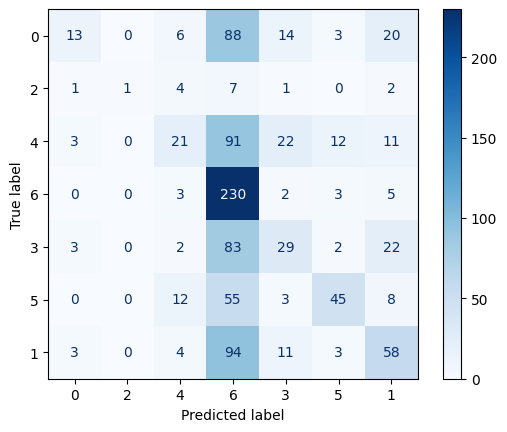

In [39]:
# Fusion Techniques - Probability Fusion
prob_fusion = (y_pred_prob_lbp + y_pred_prob_hog + y_pred_prob_sift + y_pred_prob_glcm) / 4
prob_fusion_pred = np.argmax(prob_fusion, axis=1)
accuracy_prob_fusion = accuracy_score(y_test, prob_fusion_pred)
print(f'Probability Fusion Accuracy: {accuracy_prob_fusion:.4f}')
plot_roc(y_test, prob_fusion, data['emotion'].unique())
plot_confusion_matrix(y_test, prob_fusion_pred, data['emotion'].unique())

Weighted Score Fusion Accuracy: 0.3970


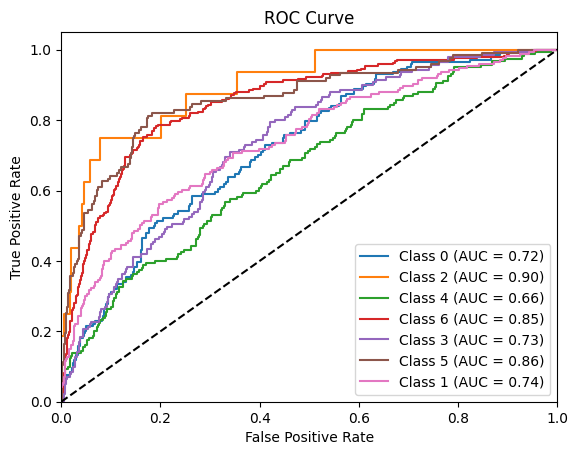

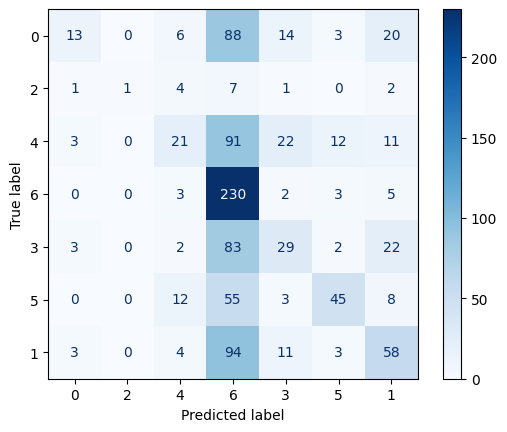

In [40]:
# Fusion Techniques - Weighted Score Fusion
weights = [0.25, 0.25, 0.25, 0.25]
weighted_fusion = (weights[0] * y_pred_prob_lbp + weights[1] * y_pred_prob_hog + weights[2] * y_pred_prob_sift + weights[3] * y_pred_prob_glcm)
weighted_fusion_pred = np.argmax(weighted_fusion, axis=1)
accuracy_weighted_fusion = accuracy_score(y_test, weighted_fusion_pred)
print(f'Weighted Score Fusion Accuracy: {accuracy_weighted_fusion:.4f}')
plot_roc(y_test, weighted_fusion, data['emotion'].unique())
plot_confusion_matrix(y_test, weighted_fusion_pred, data['emotion'].unique())
